# Nonlinear Sorption Transport (Freundlich Isotherm)

## Key Concept

When contaminants sorb nonlinearly to soil, **high concentrations travel faster** than low concentrations.

### Freundlich Isotherm
$$S = K_f \cdot C^n$$

For **favorable sorption** (n < 1):
- **Retardation**: $R(C) = 1 + \frac{\rho_b}{\theta} K_f n C^{n-1}$
- **Higher C → Lower R → Faster travel**
- **Result**: Sharp front, long tail (asymmetric breakthrough)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gwtransport.advection import infiltration_to_extraction
from gwtransport.residence_time import freundlich_retardation

print("Libraries imported successfully")

Libraries imported successfully


## Setup: Contaminant Pulse

Simulate a **Gaussian contaminant plume** entering groundwater:

In [2]:
# Time setup - optimized to minimize NaN spin-up
n_days = 300
dates = pd.date_range(start="2023-01-01", periods=n_days, freq="D")
tedges = pd.date_range(start="2022-12-31 12:00", periods=n_days + 1, freq="D")

# Flow and aquifer parameters - small pore volume for short residence time
flow = np.full(n_days, 100.0)  # Constant flow [m³/day]
pore_volume = np.array([1000.0])  # Small pore volume = short residence time

# Gaussian contaminant pulse - HIGH concentration for strong nonlinear effects
t = np.arange(n_days)
cin = 100.0 * np.exp(-0.5 * ((t - 25) / 8) ** 2)  # Peak = 100 mg/L (doubled!)

# Output window: start slightly before first arrival, end after last arrival
cout_tedges = pd.date_range(start="2022-12-31 12:00", periods=100, freq="D")  # Slightly extended

print(f"Simulation period: {n_days} days")
print(f"Peak concentration: {cin.max():.1f} mg/L at day {t[np.argmax(cin)]}")
print("Plume width (std): 8 days")
print(f"Mean residence time (no retardation): {pore_volume[0] / flow[0]:.1f} days")
print(f"Output window: {len(cout_tedges) - 1} days")

Simulation period: 300 days
Peak concentration: 100.0 mg/L at day 25
Plume width (std): 8 days
Mean residence time (no retardation): 10.0 days
Output window: 99 days


## Freundlich Retardation

Calculate concentration-dependent retardation:

In [3]:
# Freundlich parameters - strong nonlinearity for sharp peak
freundlich_k = 0.002  # Increased sorption coefficient
freundlich_n = 0.5  # Strong nonlinearity (lower n = sharper peak)
bulk_density = 1600.0  # kg/m³
porosity = 0.35

# Compute retardation for each time bin
retardation_factors = freundlich_retardation(
    concentration=cin,  # Avoid division by zero
    freundlich_k=freundlich_k,
    freundlich_n=freundlich_n,
    bulk_density=bulk_density,
    porosity=porosity,
)

# Statistics
peak_idx = np.argmax(cin)
background_idx = np.argmin(np.abs(cin - 0.1))

print(f"Retardation at peak concentration ({cin[peak_idx]:.1f} mg/L): {retardation_factors[peak_idx]:.2f}")
print(f"Retardation at background (0.1 mg/L threshold): {retardation_factors[background_idx]:.2f}")
print(f"Peak travels {retardation_factors[background_idx] / retardation_factors[peak_idx]:.2f}x faster than background")
print(f"Max residence time: {pore_volume[0] * retardation_factors.max() / flow[0]:.1f} days")
print(f"→ Strong nonlinearity: n={freundlich_n} creates sharp breakthrough!")

Retardation at peak concentration (100.0 mg/L): 1.46
Retardation at background (0.1 mg/L threshold): 16.38
Peak travels 11.24x faster than background
Max residence time: 45714295.7 days
→ Strong nonlinearity: n=0.5 creates sharp breakthrough!


## Transport Comparison

Compare four scenarios:
1. **No retardation** (R=1): Conservative tracer
2. **Nonlinear - Method of Characteristics**: Default algorithm, slight diffusion at shocks
3. **Nonlinear - Exact Front Tracking**: Sharp shock resolution, no diffusion
4. **Linear** (constant R): Average retardation

In [4]:
print("Transport calculations in progress...")

# 1. No retardation (baseline)
cout_no_retard = infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volume,
    retardation_factor=1.0,
)

# 2. Nonlinear sorption - Method of Characteristics (default)
cout_freundlich_moc = infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volume,
    retardation_factor=retardation_factors,  # Array enables nonlinear transport
    nonlinear_method="method_of_characteristics",  # Default: fast, slight diffusion
)

# 3. Nonlinear sorption - Exact Front Tracking
cout_freundlich_exact = infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volume,
    retardation_factor=retardation_factors,  # Array enables nonlinear transport
    nonlinear_method="exact_front_tracking",  # Sharp shocks, no diffusion
)

# 4. Linear sorption (mean retardation)
R_linear = np.mean(retardation_factors[cin > 1.0])
cout_linear = infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volume,
    retardation_factor=R_linear,
)

print("Transport calculations complete!\n")
print(f"No retardation (R=1): Peak = {np.nanmax(cout_no_retard):.2f} mg/L")
print(f"Freundlich (MOC): Peak = {np.nanmax(cout_freundlich_moc):.2f} mg/L")
print(f"Freundlich (Exact): Peak = {np.nanmax(cout_freundlich_exact):.2f} mg/L")
print(f"Linear (R={R_linear:.2f}): Peak = {np.nanmax(cout_linear):.2f} mg/L")

Transport calculations in progress...
Transport calculations complete!

No retardation (R=1): Peak = 100.00 mg/L
Freundlich (MOC): Peak = 99.68 mg/L
Freundlich (Exact): Peak = 99.67 mg/L
Linear (R=2.30): Peak = 99.97 mg/L


## Visualization: Asymmetric Breakthrough

**Key observation**: Freundlich creates a **sharp rising edge** (high-C arrives first) and **long tail** (low-C delayed).

In [5]:
# print(retardation_factors)
print(np.diff(cin))

[ 3.53331909e-001  4.92871274e-001  6.75647161e-001  9.10061248e-001
  1.20421403e+000  1.56503851e+000  1.99721900e+000  2.50194926e+000
  3.07562819e+000  3.70863407e+000  4.38435429e+000  5.07866684e+000
  5.76006321e+000  6.39056602e+000  6.92752343e+000  7.32626293e+000
  7.54346687e+000  7.54100915e+000  7.28988508e+000  6.77379604e+000
  5.99193402e+000  4.96055898e+000  3.71307421e+000  2.29847038e+000
  7.78206174e-001 -7.78206174e-001 -2.29847038e+000 -3.71307421e+000
 -4.96055898e+000 -5.99193402e+000 -6.77379604e+000 -7.28988508e+000
 -7.54100915e+000 -7.54346687e+000 -7.32626293e+000 -6.92752343e+000
 -6.39056602e+000 -5.76006321e+000 -5.07866684e+000 -4.38435429e+000
 -3.70863407e+000 -3.07562819e+000 -2.50194926e+000 -1.99721900e+000
 -1.56503851e+000 -1.20421403e+000 -9.10061248e-001 -6.75647161e-001
 -4.92871274e-001 -3.53331909e-001 -2.48960821e-001 -1.72438274e-001
 -1.17419537e-001 -7.86131699e-002 -5.17533112e-002 -3.35046074e-002
 -2.13317606e-002 -1.33577662e-002

Figure saved to: 06_Freundlich_Sorption_Transport.png


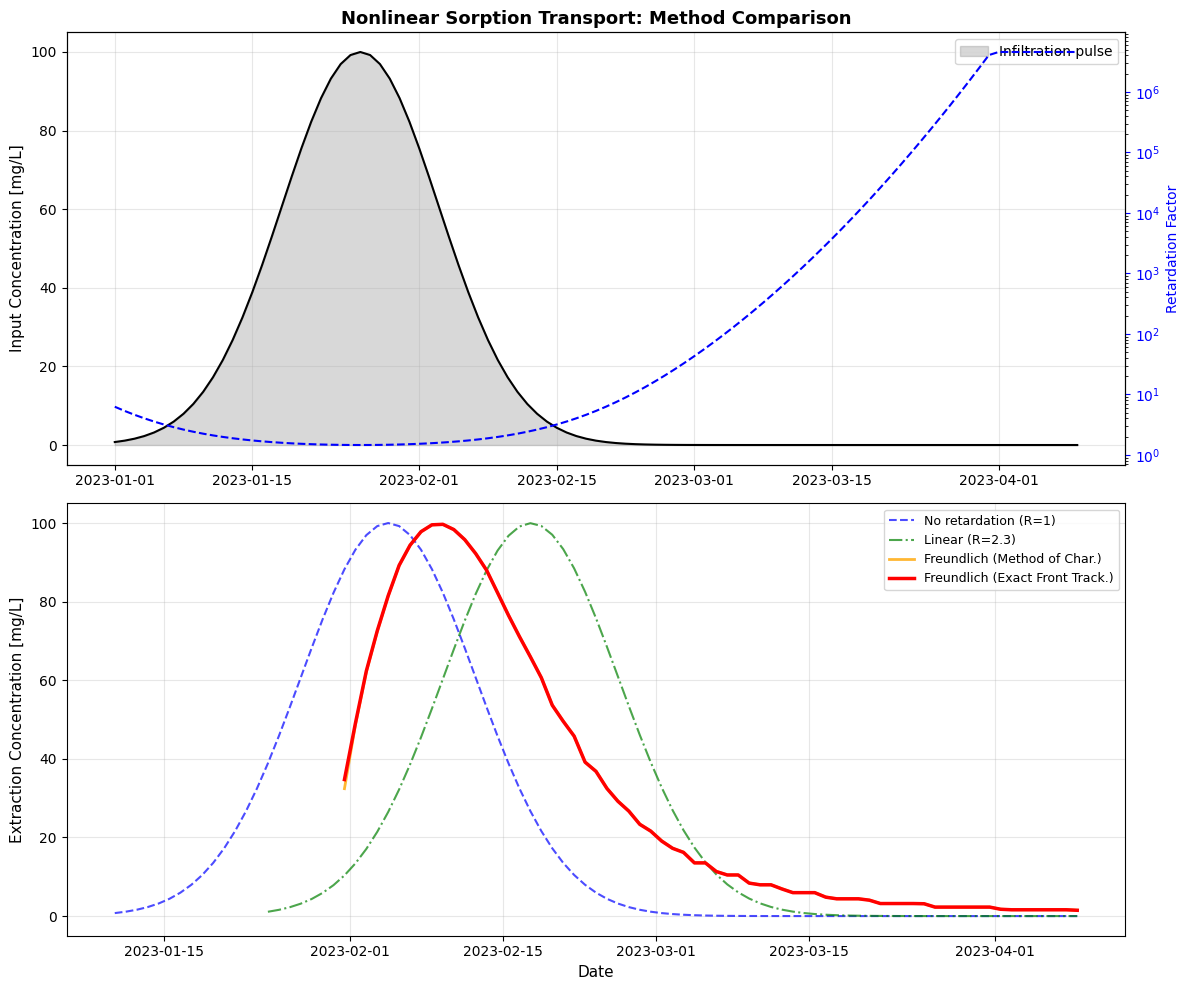

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top: Input concentration (only first window to match output)
window_size = len(cout_tedges) - 1
ax1.fill_between(dates[:window_size], cin[:window_size], alpha=0.3, color="gray", label="Infiltration pulse")
ax1.plot(dates[:window_size], cin[:window_size], "k-", linewidth=1.5)
ax1r = ax1.twinx()
ax1r.set_yscale("log")
ax1r.set_ylabel("Retardation Factor", color="b")
ax1r.tick_params(axis="y", colors="b")
ax1r.plot(dates[:window_size], retardation_factors[:window_size], "b--", label="Retardation Factor", linewidth=1.5)
ax1.set_ylabel("Input Concentration [mg/L]", fontsize=11)
ax1.set_title("Nonlinear Sorption Transport: Method Comparison", fontsize=13, fontweight="bold")
ax1.legend(loc="upper right")
ax1.grid(alpha=0.3)

# Bottom: Extraction concentrations - comparing all methods
cout_dates = cout_tedges[:-1]  # Bin centers

ax2.plot(cout_dates, cout_no_retard, "b--", label="No retardation (R=1)", linewidth=1.5, alpha=0.7)
ax2.plot(cout_dates, cout_linear, "g-.", label=f"Linear (R={R_linear:.1f})", linewidth=1.5, alpha=0.7)
ax2.plot(cout_dates, cout_freundlich_moc, "orange", linestyle="-", label="Freundlich (Method of Char.)", linewidth=2, alpha=0.8)
ax2.plot(cout_dates, cout_freundlich_exact, "r-", label="Freundlich (Exact Front Track.)", linewidth=2.5)

ax2.set_ylabel("Extraction Concentration [mg/L]", fontsize=11)
ax2.set_xlabel("Date", fontsize=11)
ax2.legend(loc="upper right", fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("06_Freundlich_Sorption_Transport.png", dpi=150, bbox_inches="tight")

print("Figure saved to: 06_Freundlich_Sorption_Transport.png")

## Key Takeaways

✅ **Nonlinear sorption creates asymmetric breakthrough curves**
- Sharp front (high-C travels fast)
- Long tail (low-C travels slow)

✅ **Linear models (constant R) miss this behavior**
- Underpredict early arrival
- Overpredict peak concentration
- Underpredict tail duration

✅ **Two Methods for Nonlinear Transport**

When `retardation_factor` is an array (concentration-dependent), choose between:

1. **`nonlinear_method="method_of_characteristics"` (default)**
   - Fast and robust
   - Slight numerical diffusion at shocks
   - Good for most applications

2. **`nonlinear_method="exact_front_tracking"`**
   - Maintains sharp concentration fronts
   - No numerical diffusion
   - Best for: sharp gradients, shock waves, high accuracy requirements
   - Slightly more computationally expensive

**Usage:**
```python
# Default method (fast)
cout = infiltration_to_extraction(
    cin=cin, flow=flow, tedges=tedges, cout_tedges=cout_tedges,
    aquifer_pore_volumes=pv,
    retardation_factor=R_array,  # Array enables nonlinear
    nonlinear_method="method_of_characteristics"  # Default
)

# Exact method (sharp shocks)
cout = infiltration_to_extraction(
    cin=cin, flow=flow, tedges=tedges, cout_tedges=cout_tedges,
    aquifer_pore_volumes=pv,
    retardation_factor=R_array,  # Array enables nonlinear
    nonlinear_method="exact_front_tracking"  # Sharp fronts
)
```

✅ **Applications**:
- Organic contaminant transport
- Heavy metal migration
- Pesticide fate and transport
- Pharmaceutical transport in groundwater
- Any system with concentration-dependent sorption